# Example `Dysmalpy` built-in masking routine

This notebook expands on `dysmalpy_example_fitting_wrapper_3D.ipynb` to demonstrate Dysmalpy's built-in masking function. 

It can mask out skylines and exclude low SNR regions. 

Manual inspection of the masking quality is strongly advised. 

For more advanced masking, users can provide their own 3D mask, which is beyond the scope of this tutorial.

## 1) Setup steps ##

**Import modules**

In [310]:
import sys,os
from os.path import dirname
sys.path.insert(0,"/Users/lilianlee/git_softwares/dysmalpy/")

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from dysmalpy.fitting_wrappers import dysmalpy_fit_single
from dysmalpy.fitting_wrappers import utils_io
from dysmalpy import fitting, plotting


import numpy as np
import dysmalpy


from astropy.io import fits

from matplotlib.patches import Rectangle

**Setup notebook**

In [311]:
# Setup plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

from IPython.core.display import Image


**Set data, output paths**

In [265]:
# Data directory (datadir = /YOUR/DATA/PATH/)
filepath = os.path.abspath(fitting.__file__)
datadir = os.sep.join(os.path.dirname(filepath).split(os.sep)[:-2]+["tests", "test_data", ""])

param_path = os.sep.join(os.path.dirname(filepath).split(os.sep)[:-2]+["examples", "examples_param_files", ""])
param_filename = param_path+'fitting_3D_mpfit_temp.params'

# Where to save output files (output = /YOUR/OUTPUTS/PATH)
outdir = '/Users/lilianlee/Documents/dysmalpy_testing_output_temp/'

outdir_mpfit = outdir + 'MPFIT/'


**Settings in parameter file:**

Note there are many commented out options / parameters. These given an more complete overview of the settings & parameters that can be specified with the fitting wrapper parameter files.

In [139]:
with open(param_filename, 'r') as f:
    print(f.read())

## Case 1: Single emission IFU data contaminated by skylines

## Visualise the masking regions

The skylines to be masked can be visualised by a position-velocity (PV) diagram extracted along the kinematic major axis at a PA = $142^{\circ}$. 

The PV diagram here is plotted with velocity (wavelength) on the horizontal axis and position on the vertical axis. 

The S-shaped emission within the red rectangle that arises from the rotation of the galaxy is our region of interest. 

On either side of this S-shaped emission, there are vertical stripes along the velocity axis. These vertical stripes represent the unwanted skylines that we aim to mask out.

We will also mask the regions where the integrated S/N is too low for robust kinematic extraction, which in general corresponds to the outskirt of the galaxies, so the regions on top and below of the "S-shaped" emission will also be masked.

(-0.5, 1374.5, -0.5, 90.5)

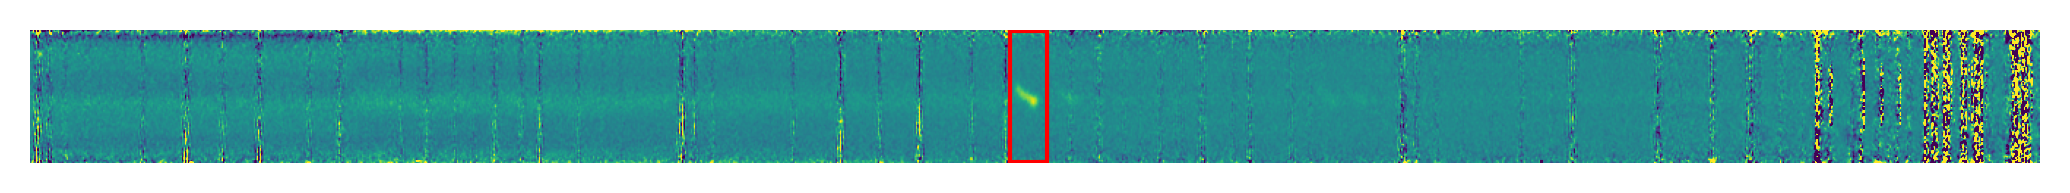

In [271]:
pv_maj = fits.open("../../tests/test_data_masking/gs4-43501_h250_21h30_pvmaj.fits")

fig, ax = plt.subplots(1,1,tight_layout=True,figsize = (7,1))

ax.imshow(pv_maj[0].data,vmin=-3.383e-18, vmax=3.825e-18, origin="lower")
ha_pv_region = Rectangle((670,0), 25, 90, edgecolor="r", facecolor="none", lw=1)
ax.add_patch(ha_pv_region)
plt.axis('off')

## Setup masking parameters
Setting up masking parameters is done differently here. Instead of relying on the parameters defined in the parameter file, we now specify the values as arguments when calling `utils_io.generate_3D_mask`. In our first demo, we will use the default parameters originally specified in the parameter file.

In [267]:
params = utils_io.read_fitting_params(fname=param_filename)
gal = utils_io.load_galaxy(params=params, datadir=datadir, skip_mask=True, skip_automask=True)
T

mask_v1, mask_dict_v1 = utils_io.generate_3D_mask(obs=gal.observations['OBS'],
                                                    params=params,
                                                    sig_segmap_thresh = 3.25,
                                                    npix_segmap_min = 5,
                                                    snr_int_flux_thresh = 3,
                                                    snr_thresh_pixel    = None,
                                                    sky_var_thresh      = 2,
                                                    apply_skymask_first = True  
                                                   )


INFO:DysmalPy:dysmalpy.Galaxy:
********************************************************************
*** INFO ***
instrument.fov[0,1]=(37,37) is being reset to match 3D cube (31, 31)
********************************************************************

INFO:DysmalPy:dysmalpy.Galaxy:
********************************************************************
*** INFO ***
instrument spectral settings are being reset
   (spec_type=velocity, spec_start=-1000.00 km / s, spec_step=10.00 km / s, nspec=201)
   to match 3D cube
   (spec_type=velocity, spec_start=-484.72 km / s, spec_step=34.08 km / s, nspec=29)
********************************************************************



++++++++++++++++++++++++++++++++++++++++++++++++++++++
  Creating 3D auto mask with the following settings: 
        sig_segmap_thresh   = 3.25 
        npix_segmap_min     = 5 
        snr_int_flux_thresh = 3 
        snr_thresh_pixel    = None 
        sky_var_thresh      = 2 
        apply_skymask_first = True 
++++++++++++++++++++++++++++++++++++++++++++++++++++++

 Masking segmap: used exclude_percentile=15.0


**Examine mask info**

Quick look at the integrated spatial flux maps and segmaps

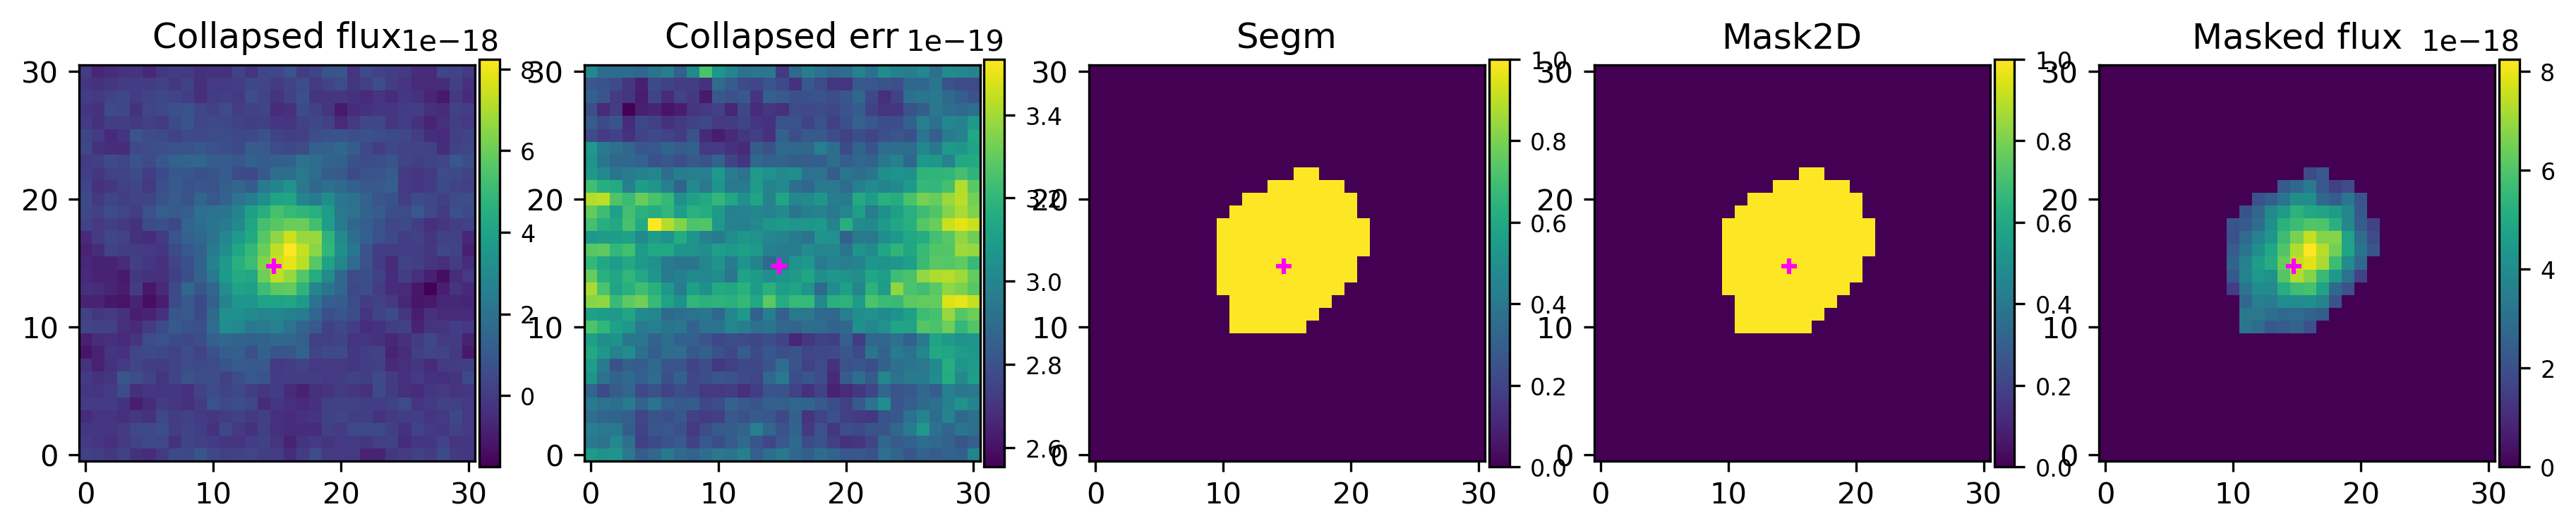

In [272]:
plotting.plot_3D_data_automask_info(gal.observations['OBS'], mask_dict)

## Save the mask

In [274]:
utils_io.save_3D_mask(obs=gal.observations['OBS'], mask=mask, 
                      filename=datadir+params['fdata_mask'], 
                      save_uncropped_size=True, overwrite=True)

## Mask inspection (optional)
To examine the masked regions, you can multiply the 3D mask with the data cube which is already done here.

By default, the mask does not contain spectral unit information in the header. However, this doesn't impact its functionality as a mask, as it matches with the cube's dimensions.

We once again use PV diagram to inspect if the cubes are sufficiently masked.


(-0.5, 1374.5, -0.5, 90.5)

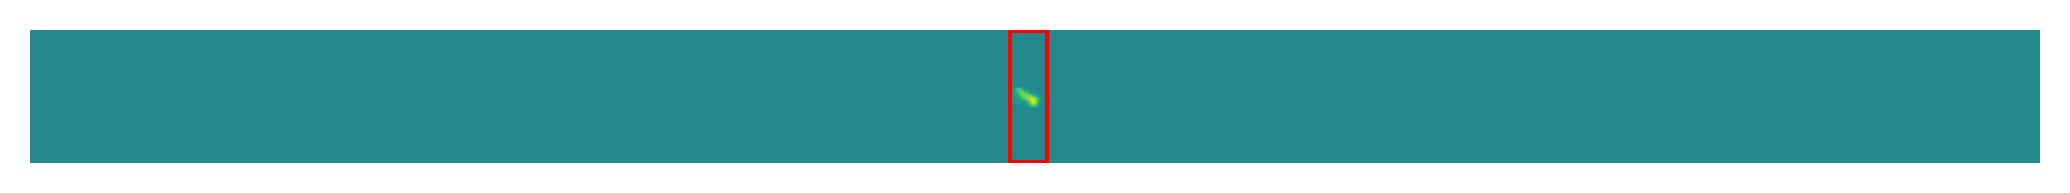

In [275]:
pv_maj_masked = fits.open("../../tests/test_data_masking/gs4-43501_h250_21h30_pvmaj_masked.fits") 
fig, ax = plt.subplots(1,1,tight_layout=True,figsize = (7,1))
plt.imshow(pv_maj_masked[0].data,vmin=-3.383e-18, vmax=3.825e-18,origin="lower")
ha_pv_region = Rectangle((670,0), 25, 90, edgecolor="r", facecolor="none", lw=1)
ax.add_patch(ha_pv_region)
plt.axis('off')

## Case 2: Data cube free from skylines contamination
In this case only spatial masking is necessasry. To demonstrate it, we use a mock data cube that simulates a low SNR IFU data. The spectral axis in this case represents velocity.

In [302]:
param_filename = "../../tests/test_data_masking/lowsn_mock.params"
datadir =  os.sep.join(os.path.dirname(filepath).split(os.sep)[:-2]+["tests", "test_data_masking", ""])

params = utils_io.read_fitting_params(fname=param_filename)
gal = utils_io.load_galaxy(params=params, 
                           datadir=datadir, 
                           skip_mask=True, 
                           skip_automask=True,
                           skip_auto_truncate_crop=True
                           )

INFO:DysmalPy:dysmalpy.Galaxy:
********************************************************************
*** INFO ***
instrument spectral settings are being reset
   (spec_type=velocity, spec_start=-500.00 km / s, spec_step=10.00 km / s, nspec=101)
   to match 3D cube
   (spec_type=velocity, spec_start=-1000.00 km / s, spec_step=10.00 km / s, nspec=201)
********************************************************************



## PV diagram
As previously, the horizontal axis represents the velocity, while the vertical axis represents position. 

In contrast to Case 1, this cube is clearly free from skylines contamination, so no spectral masking is necessary.

(-0.5, 200.5, -0.5, 50.5)

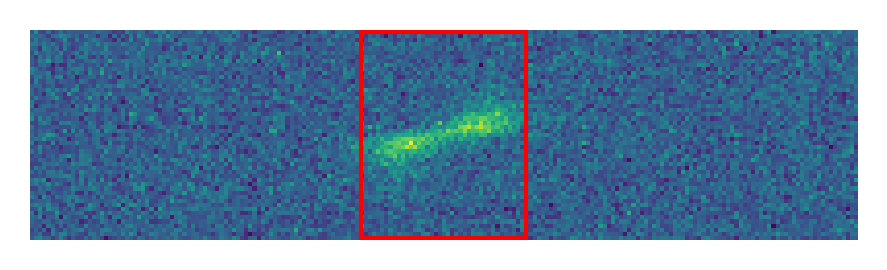

In [317]:
pv_maj = fits.open("../../tests/test_data_masking/lowsn_mock_pvmaj.fits")

fig, ax = plt.subplots(1,1,tight_layout=True,figsize = (7,1))

ax.imshow(pv_maj[0].data,vmin=-0.2, vmax=0.45, origin="lower")
mock_pv_region = Rectangle((80,0), 40, 50, edgecolor="r", facecolor="none", lw=1)
ax.add_patch(mock_pv_region)
plt.axis('off')

In [321]:
mask_v3, mask_dict_v3 = utils_io.generate_3D_mask(obs=gal.observations['OBS'],
                                                    params=params,
                                                    sig_segmap_thresh = 1.5, #lower than before as the cube is more noisy
                                                    npix_segmap_min = 5,
                                                    snr_int_flux_thresh = 3,
                                                    snr_thresh_pixel    = None,
                                                    sky_var_thresh      = None, #None because this cube doesn't contain skylines
                                                    apply_skymask_first = True
                                                   )

++++++++++++++++++++++++++++++++++++++++++++++++++++++
  Creating 3D auto mask with the following settings: 
        sig_segmap_thresh   = 1.5 
        npix_segmap_min     = 5 
        snr_int_flux_thresh = 3 
        snr_thresh_pixel    = None 
        sky_var_thresh      = 2 
        apply_skymask_first = True 
++++++++++++++++++++++++++++++++++++++++++++++++++++++



**Examine mask info**

Quick look at the integrated spatial flux maps and segmaps

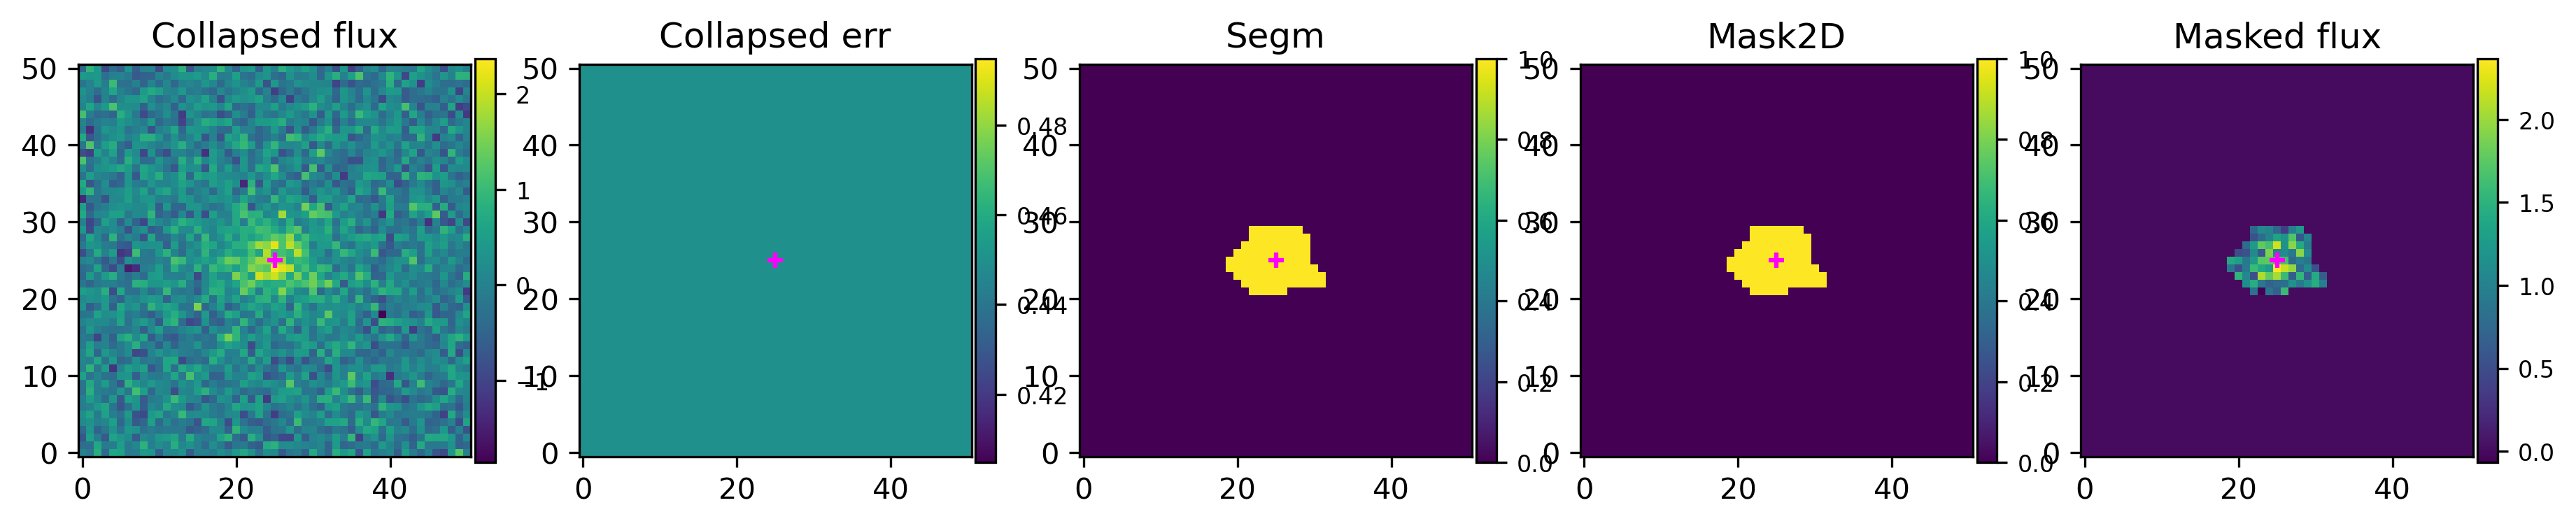

In [318]:
plotting.plot_3D_data_automask_info(gal.observations['OBS'], mask_dict_v3)

## Save the mask

In [314]:
utils_io.save_3D_mask(obs=gal.observations['OBS'], mask=mask_v3, 
                      filename=datadir+params['fdata_mask'], 
                      save_uncropped_size=True, overwrite=True)

## Mask inspection (optional)

(-0.5, 200.5, -0.5, 50.5)

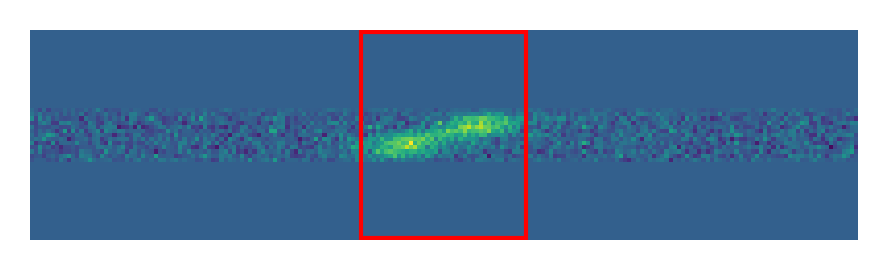

In [320]:
pv_maj = fits.open("../../tests/test_data_masking/lowsn_mock_pvmaj_masked.fits")

fig, ax = plt.subplots(1,1,tight_layout=True,figsize = (7,1))

ax.imshow(pv_maj[0].data,vmin=-0.2, vmax=0.45, origin="lower")
mock_pv_region = Rectangle((80,0), 40, 50, edgecolor="r", facecolor="none", lw=1)
ax.add_patch(mock_pv_region)
plt.axis('off')